# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [82]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.stats import chi2_contingency
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [83]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [110]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
#         hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        cv = CountVectorizer(lowercase=True, ngram_range=(1, 3), analyzer="char_wb")
        X_cv = cv.fit_transform(movie_data.review)
        fitted_transformations.append(cv)
        print("Shape of CountVectorizer X:")
        print(X_cv.shape)
    else: # transform() 
        X_cv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of CountVectorizer X:")
        print(X_cv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_cv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_cv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
#     movie_data['word_counts'] = Counter(movie_data['review'].split())
    movie_data['repeated_word_count'] = [word for word, count in movie_data['word_count'].items() if count > 1]
    movie_data['unique_word_count'] = movie_data['review'].apply(lambda x: len(set(x.split())))
    movie_data['avg_word_length'] = movie_data['review'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))

    
#     # Chi-squared test to select top categorical features
#     if (not test):
#         top_features = []
#         for col in ['word_count', 'punc_count', 'repeated_words']:
#             crosstab = pd.crosstab(movie_data[col], movie_data['sentiment'])
#             chi2, p, dof, expected = chi2_contingency(crosstab)
#             if p < 0.05:
#                 top_features.append(col)
#         print("Top categorical features selected using chi-squared test: ")
#         print(top_features)
#         movie_data = movie_data[top_features]
        
        
    X_quant_features = movie_data[["word_count", "punc_count", "repeated_word_count", "unique_word_count", "avg_word_length"]]
#     X_quant_features = movie_data[top_features]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [111]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/maybaho/Documents/Parsons/Machine Learning/assignments/data/moviereviews_train.tsv', my_random_seed=13)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of CountVectorizer X:
(25000, 38406)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  repeated_word_count  unique_word_count  \
0         433          20                    0                246   
1         158        

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [ ]:
# from sklearn import linear_model
# ols = linear_model.SGDClassifier(loss="squared_loss", penalty="elasticnet", alpha=0.001)
# ols.fit(X_train, y_train)

# ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
# ols_performance_train.compute_measures()
# print(ols_performance_train.performance_measures)

### MODEL: SVM, linear

In [ ]:
# from sklearn import linear_model
# svm = linear_model.SGDClassifier()
# svm.fit(X_train, y_train)

# svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
# svm_performance_train.compute_measures()
# print(svm_performance_train.performance_measures)

### MODEL: logistic regression

In [ ]:
# from sklearn import linear_model
# lgs = linear_model.SGDClassifier(loss='log')
# lgs.fit(X_train, y_train)

# lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
# lgs_performance_train.compute_measures()
# print(lgs_performance_train.performance_measures)

### MODEL: Naive Bayes

In [112]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB(fit_prior=True, alpha=0.001)
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 9003, 'TN': 9130, 'FP': 868, 'FN': 999, 'Accuracy': 0.90665, 'Precision': 0.9120656468442914, 'Recall': 0.9001199760047991, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [ ]:
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron')
# prc.fit(X_train, y_train)

# prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
# prc_performance_train.compute_measures()
# print(prc_performance_train.performance_measures)

### MODEL: Ridge Regression Classifier

In [36]:
# from sklearn import linear_model
# rdg = linear_model.RidgeClassifier()
# rdg.fit(X_train, y_train)

# rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
# rdg_performance_train.compute_measures()
# print(rdg_performance_train.performance_measures)

### MODEL: Random Forest Classifier

In [37]:
# from sklearn.ensemble import RandomForestClassifier
# rdf = RandomForestClassifier(max_depth=2, random_state=0)
# rdf.fit(X_train, y_train)

# rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
# rdf_performance_train.compute_measures()
# print(rdf_performance_train.performance_measures)

### ROC plot to compare performance of various models and fits

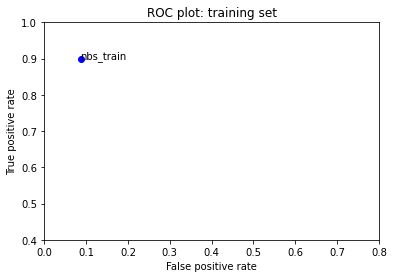

In [113]:
fits = [nbs_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 0.8, 0.4, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [94]:
nbs_predictions = nbs.predict(X_train)

### let's look at some false positives:

In [95]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(nbs_predictions)):
    if (nbs_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
653
I can't really say what I think about this movie, its against the guidelines, I've watched many many films, and this has got to be the worst one yet, Extremely low budget, I'm guessing all the money went into the slaughter house scenes, cause I could of did a better job with a b&w 8mm camera and a crew of monkeys. It was so bad I registered just to leave a comment, cause I had to tell someone, movie rental place wasn't enough. But this is my 2 cents worth, I suggest borrowing it from some poor sap who rented it and watch it yourself. Cause i sure wouldn't waste the money on it myself again. Now i leave you with this comment. I hope your not made at the rental place when they wont refund you your money .. =)
* * * * * * * * * 
903
Whoever wrote the screenplay for this movie obviously never consulted any books about Lucille Ball, especially her autobiography. I've never seen so many mistakes in a biopic, ranging from her early years in Celoron and Jamesto

4394
I was very displeased with this move. Everything was terrible from the start. The comedy was unhumorous, the action overdone, the songs unmelodious. Even the storyline was weightless. From a writer who has written successful scripts like Guru and Dhoom, I had high expectations. The actors worked way too hard and did not help the film at all. Of course, Kareena rocked the screen in a bikini but for two seconds. I think Hindi stunt directors should research how action movies are done. They tend to exaggerate way too much. In Chinese films, this style works because that is their signature piece. But, Hindi cinema's signature are the songs. A good action movie should last no more than two hours and cannot look unrealistic. But, in the future, I'm sure these action movies will get much sharper. Also to be noted: Comedy and action films do not mix unless done properly. Good Luck next time.
* * * * * * * * * 
5300
Hoo boy, this was a real trial to get through. The DVD case has Tom Hanks'

13103
The plot of this film is not strong at all, lots of holes. If you approach it as a car movie its not bad, lots of great cars in this one. The reason I like it is because I am from the area where this was filmed. I get the most enjoyment looking at the recognizable places in St. Cloud MN and seeing how the town has changed since 89. Its an interesting historical piece for us locals. Seems like whenever a film is made here everyone wants some relationship to it. It is impossible to find a copy in any of the local video stores as they were all stolen once it came out on VHS. Had to get a copy from Japan on Ebay I find it interesting how the path of the drag race is all over town. I didn't know the director was from St.Cloud.
* * * * * * * * * 
13128
Sort of family parody blending \An Officer And A Gentleman\", \"Heartbreak Ridge\", \"Full Metal Jacket\" (and without doubt other movies I am not able to remember now) into a rather dull movie, with some bright spots. The gags are alway

17569
The movie had so much potential, but due to 70's technology constraints and also a weak script killed the main plot of the film. The book version of the film was much better, and well conceived. If it had been done right in the beginning with sources from the book, it could have been a very cool classic.
* * * * * * * * * 
17597
From the mind of Harry Alan Towers comes another piece of cinematic sludge. Supposedly based on the work of H. Rider Haggard, the only similarity it bears to anything Haggard actually wrote is that it takes place in Africa (albeit an Africa that has dinosaurs - which our intrepid adventurers use to pull their canoes!), and has some characters with the same names.<br /><br />Our heroes (David McCallum, Patrick McNee and John Colico) set out to seek treasure, armed only with a medallion, and end up precisely where the treasure is, purely by chance. On the way, they meet a motley assortment of extremely lame monsters, pick up a French chef, and McCallum has 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [17]:
# ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
# ols_performance_test.compute_measures()
# print(ols_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 1250, 'TN': 1310, 'FP': 1192, 'FN': 1248, 'Accuracy': 0.512, 'Precision': 0.5118755118755118, 'Recall': 0.500400320256205, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [18]:
# svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
# svm_performance_test.compute_measures()
# print(svm_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2062, 'TN': 2077, 'FP': 425, 'FN': 436, 'Accuracy': 0.8278, 'Precision': 0.8291113791716928, 'Recall': 0.8254603682946358, 'desc': 'svm_test'}


### MODEL: logistic regression

In [19]:
# lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
# lgs_performance_test.compute_measures()
# print(lgs_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2106, 'TN': 2069, 'FP': 433, 'FN': 392, 'Accuracy': 0.835, 'Precision': 0.8294604174871997, 'Recall': 0.8430744595676541, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [96]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 1725, 'TN': 1762, 'FP': 740, 'FN': 773, 'Accuracy': 0.6974, 'Precision': 0.6997971602434077, 'Recall': 0.6905524419535628, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [21]:
# prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
# prc_performance_test.compute_measures()
# print(prc_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2085, 'TN': 2087, 'FP': 415, 'FN': 413, 'Accuracy': 0.8344, 'Precision': 0.834, 'Recall': 0.8346677341873499, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [22]:
# rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
# rdg_performance_test.compute_measures()
# print(rdg_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2070, 'TN': 1990, 'FP': 512, 'FN': 428, 'Accuracy': 0.812, 'Precision': 0.801704105344694, 'Recall': 0.8286629303442754, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [23]:
# rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
# rdf_performance_test.compute_measures()
# print(rdf_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2043, 'TN': 1784, 'FP': 718, 'FN': 455, 'Accuracy': 0.7654, 'Precision': 0.7399492937341543, 'Recall': 0.8178542834267414, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

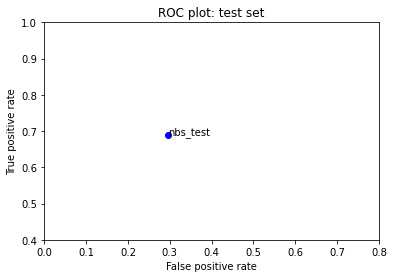

In [97]:
fits = [nbs_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 0.8, 0.4, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [98]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/maybaho/Documents/Parsons/Machine Learning/assignments/data/moviereviews_test.tsv', my_random_seed=13, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 38406)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  repeated_words
0         131           5               0
1         169          15               1
2         176          18               2
3         112           5               3
4         133           8               4
5         331          20              

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [99]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = nbs.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.47012


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,1
2,5828_4,1
3,7186_2,1
4,12128_7,0


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/maybaho/Documents/Parsons/Machine Learning/assignments/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation